In [1]:
import tensorflow as tf

import math
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score 
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#check if GPU enabled or not in tensorflow
import tensorflow
print("Num GPUs Available: ", tensorflow.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Defining data paths

In [9]:
train_path = r'D:\Faculty Work\Master\Work\melanoma skin cancer detection\Implementation\DataSet\ISIC2019\data2019v5\training80'
test_path = r'D:\Faculty Work\Master\Work\melanoma skin cancer detection\Implementation\DataSet\ISIC2019\data2019v5\testing10_segmented'
val_path = r'D:\Faculty Work\Master\Work\melanoma skin cancer detection\Implementation\DataSet\ISIC2019\data2019v5\validation10_segmented'

# Converting image to pixels 

melanoma


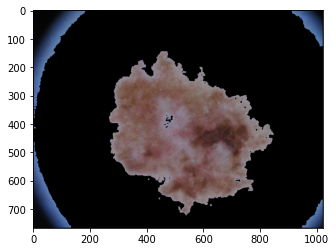

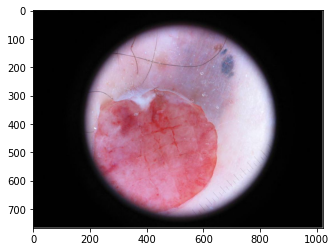

non_melanoma


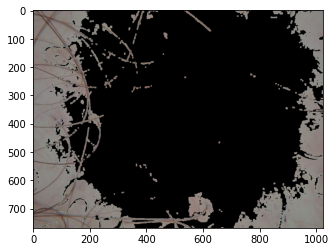

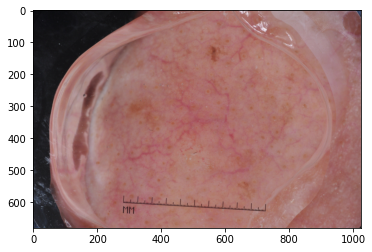

In [10]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder
    
    print(folder)
    
    image_samples = os.listdir(sub_path)
    
    for i in range(2):
        img = mpimg.imread(sub_path + "/" +image_samples[i])
        imgplot = plt.imshow(img)
        plt.show()

In [11]:

def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path=path+"/"+folder

        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            img_arr=cv2.resize(img_arr, size)
            data.append(img_arr)
            
    return data


In [12]:
size = (224,224)

train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)

# Normalization

In [13]:
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [14]:
# Just test images dimensions after converting images to numbers in one variable
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(5716, 224, 224, 3)
(716, 224, 224, 3)
(714, 224, 224, 3)


In [15]:
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

In [16]:
#check dimensions after normalization
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(5716, 224, 224, 3)
(716, 224, 224, 3)
(714, 224, 224, 3)


# Defining target variables

In [17]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 32,
                                          class_mode = class_mode)
    return classes

In [18]:
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
val_class = data_class(val_path, size, 'sparse')

Found 5716 images belonging to 2 classes.
Found 716 images belonging to 2 classes.
Found 714 images belonging to 2 classes.


In [19]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [20]:
train_class.class_indices

{'melanoma': 0, 'non_melanoma': 1}

In [21]:
test_class.class_indices

{'melanoma': 0, 'non_melanoma': 1}

In [22]:
y_train.shape,y_test.shape,y_val.shape

((5716,), (716,), (714,))

# GoogleNet Model (InceptionV1)

# Inception arichetecture : will bw used in our model
# 9 inceptions each one with 6 conv layers and MaxPooling

In [2]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [3]:
kernel_init = tf.keras.initializers.glorot_uniform()
bias_init = tf.keras.initializers.Constant(value=0.2)

In [4]:
input_layer = Input(shape=(224, 224, 3))

# Main Model

In [5]:
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')

x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(1, activation='sigmoid', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(1, activation='sigmoid', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid', name='output')(x)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [7]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [8]:
epochs = 29

#for different optimizer usually used with GoogleNet


def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

initial_lrate = 0.01
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

#call Back based on learning Rate
lr_sc = LearningRateScheduler(decay, verbose=1)



In [23]:
#compile using learning rate call back and sgd optimizer defined in previous section
model.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), callbacks=[lr_sc], epochs=epochs, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5716 samples, validate on 714 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/29
5716/5716 [==============================] - 400s 70ms/sample - loss: 1.1547 - output_loss: 0.7323 - auxilliary_output_1_loss: 0.7027 - auxilliary_output_2_loss: 0.7052 - output_acc: 0.4939 - auxilliary_output_1_acc: 0.5177 - auxilliary_output_2_acc: 0.4902 - val_loss: 1.1159 - val_output_loss: 0.6997 - val_auxilliary_output_1_loss: 0.6946 - val_auxilliary_output_2_loss: 0.6991 - val_output_acc: 0.5000 - val_auxilliary_output_1_acc: 0.5000 - val_auxilliary_output_2_acc: 0.5000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/29
5716/5716 [==============================] - 358s 63ms/sample - loss: 1.1159 - output_loss: 0.7014 - auxilliary_output_1_loss: 0.6902 - auxilliary_output_2_loss: 0.6920 - output_acc: 0.5138 - auxilliary_output_1_acc: 0.


Epoch 00015: LearningRateScheduler reducing learning rate to 0.0096.
Epoch 15/29
5716/5716 [==============================] - 352s 62ms/sample - loss: 0.8025 - output_loss: 0.5019 - auxilliary_output_1_loss: 0.5000 - auxilliary_output_2_loss: 0.4999 - output_acc: 0.7699 - auxilliary_output_1_acc: 0.7659 - auxilliary_output_2_acc: 0.7698 - val_loss: 0.8916 - val_output_loss: 0.5573 - val_auxilliary_output_1_loss: 0.5758 - val_auxilliary_output_2_loss: 0.5641 - val_output_acc: 0.7297 - val_auxilliary_output_1_acc: 0.7227 - val_auxilliary_output_2_acc: 0.7199

Epoch 00016: LearningRateScheduler reducing learning rate to 0.009216.
Epoch 16/29
5716/5716 [==============================] - 354s 62ms/sample - loss: 0.8059 - output_loss: 0.5057 - auxilliary_output_1_loss: 0.4996 - auxilliary_output_2_loss: 0.5006 - output_acc: 0.7591 - auxilliary_output_1_acc: 0.7642 - auxilliary_output_2_acc: 0.7610 - val_loss: 0.9512 - val_output_loss: 0.6006 - val_auxilliary_output_1_loss: 0.5902 - val_auxi

5716/5716 [==============================] - 355s 62ms/sample - loss: 0.7053 - output_loss: 0.4420 - auxilliary_output_1_loss: 0.4385 - auxilliary_output_2_loss: 0.4374 - output_acc: 0.7969 - auxilliary_output_1_acc: 0.8002 - auxilliary_output_2_acc: 0.7967 - val_loss: 0.9116 - val_output_loss: 0.5686 - val_auxilliary_output_1_loss: 0.5921 - val_auxilliary_output_2_loss: 0.5701 - val_output_acc: 0.7143 - val_auxilliary_output_1_acc: 0.6891 - val_auxilliary_output_2_acc: 0.7059


In [ ]:

#compile using adam optimizer in cnn models usually used with classification problems

#model.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer='adam', metrics=['accuracy'])

#call Back based on Validation loss value on Training

#early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)
#history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), epochs=epochs, callbacks=[early_stop], batch_size=32)

In [ ]:
#no call back used on training process and compile based on adam optimizer

#model.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer='adam', metrics=['accuracy'])
#history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), epochs=epochs, batch_size=32)

# Visualization

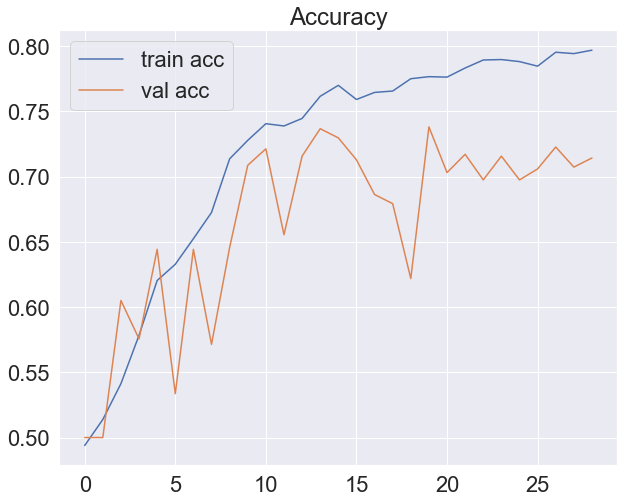

In [38]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['output_acc'], label='train acc')
plt.plot(history.history['val_output_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

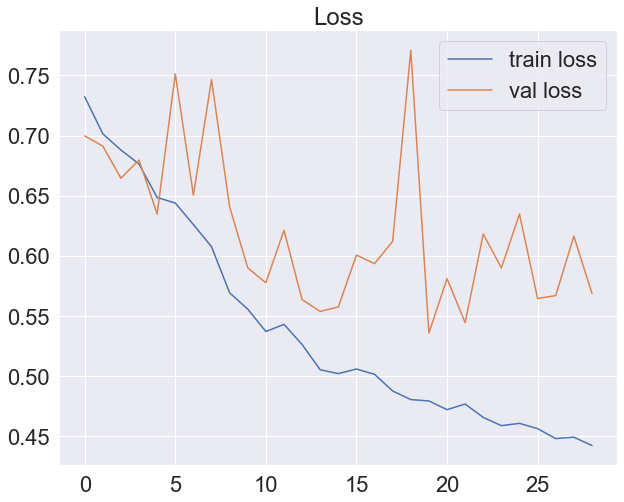

In [40]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['output_loss'], label='train loss')
plt.plot(history.history['val_output_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# model evaluation

In [26]:
model.evaluate(x_test, [y_test,y_test,y_test], batch_size=32)

716/716 [==============================] - 20s 27ms/sample - loss: 0.7242 - output_loss: 0.4563 - auxilliary_output_1_loss: 0.4706 - auxilliary_output_2_loss: 0.4552 - output_acc: 0.7807 - auxilliary_output_1_acc: 0.7807 - auxilliary_output_2_acc: 0.7919


[0.7241956122094693,
 0.4563004,
 0.47060978,
 0.4551669,
 0.78072625,
 0.78072625,
 0.79189944]

# Confusion Matrix

In [27]:
y_pred = model.predict(x_test)

In [34]:
# in googleNet we have 3 outputs and most used is output 3 the last output
print(type(y_pred))

print(np.shape(y_pred))

print(y_pred[0])

<class 'list'>
(3, 716, 1)
[[0.62552553]
 [0.12525955]
 [0.01622933]
 [0.04109555]
 [0.11787552]
 [0.01712134]
 [0.00812832]
 [0.26430434]
 [0.03200477]
 [0.04374707]
 [0.03058547]
 [0.09741563]
 [0.00833625]
 [0.04353493]
 [0.0305531 ]
 [0.05735445]
 [0.06127402]
 [0.01620364]
 [0.08263484]
 [0.21808052]
 [0.26543725]
 [0.33382884]
 [0.12324992]
 [0.0441795 ]
 [0.00351545]
 [0.3149764 ]
 [0.00969306]
 [0.20454326]
 [0.7758902 ]
 [0.02582285]
 [0.0041995 ]
 [0.03004357]
 [0.00866833]
 [0.08222026]
 [0.7275963 ]
 [0.02174255]
 [0.06372926]
 [0.08848736]
 [0.17444712]
 [0.18019256]
 [0.09646782]
 [0.27034557]
 [0.00922567]
 [0.06764203]
 [0.04854676]
 [0.07016098]
 [0.03751624]
 [0.48323125]
 [0.04511642]
 [0.09552351]
 [0.0347532 ]
 [0.01542458]
 [0.03532133]
 [0.00698304]
 [0.01590514]
 [0.07190523]
 [0.02085727]
 [0.09231845]
 [0.1130304 ]
 [0.09630588]
 [0.12577772]
 [0.04480535]
 [0.73447216]
 [0.03405958]
 [0.35944888]
 [0.04221618]
 [0.04980117]
 [0.20532632]
 [0.05243593]
 [0.051

In [48]:
#output of the last one in googleNet index =2 to use it to get confusion matrix results
print(y_pred[2][63])

[0.49299097]


In [47]:
#output of the last one in googleNet index =2 to use it to get confusion matrix results
print(y_pred[2][63][0])

0.49299097


In [49]:
#thresholding results of y_pred[2] in >=0.5  make it 1 otherwise 0 (Binary Classification)

y_pred_third_output=[]

for i in range(0,716):
    if (y_pred[0][i][0]>=0.5):
        y_pred_third_output.append(1)
    else:
        y_pred_third_output.append(0)



#multiclassification problems
#y_pred=np.argmax(y_pred,axis=1)

In [50]:
print(y_pred_third_output)

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 

In [51]:
#multiclassification problems
print(classification_report(y_pred_third_output,y_test))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79       373
           1       0.76      0.79      0.78       343

    accuracy                           0.78       716
   macro avg       0.78      0.78      0.78       716
weighted avg       0.78      0.78      0.78       716



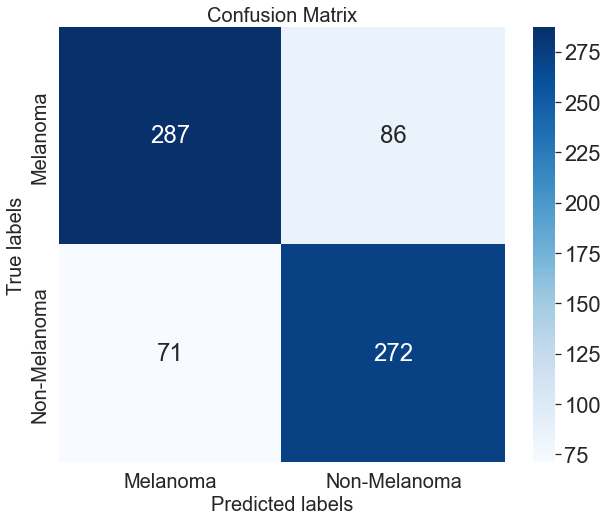

In [52]:
cm = confusion_matrix(y_pred_third_output,y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=20); 
ax.xaxis.set_ticklabels(['Melanoma', 'Non-Melanoma'], fontsize=20); ax.yaxis.set_ticklabels(['Melanoma', 'Non-Melanoma'], fontsize=20);

In [53]:
f1_score(y_test, y_pred_third_output)

0.776034236804565

In [54]:
recall_score(y_test, y_pred_third_output)

0.7597765363128491

In [55]:
precision_score(y_test, y_pred_third_output)

0.793002915451895

# saving model

In [36]:
model.save("model.h5")